# CS146 Assignment 3
## Isaac Schaal

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from scipy import stats

##  1. Exponential Likelihood with Gamma Prior

In this exercise we are modeling the number of phone calls we expect into the call center during the 11th hour of the day.

We have a data set of the intervals between phone calls arriving during one day. Each value is a time in minutes indicating the amount of time that passed between recieving two consecutive phone calls. The data for the whole day was provided, but only the data from the 11th hour was used.

For this model, we are using an exponential liklihood function. The exponential distribution describes the time between events in a process in which events occur continuosuly and indipendently at a constant average rate. This describes our telephone scenario, and thus the likelihood function is appropriate.

The exponential liklihood has one parameter, the rate, λ. We are using a gamma distribution with alpha = 1 and beta = 0.25 as our prior. These fixed prior hyperparameters were provided in the task. 

Because the gamma is a conjugate prior distribution to the exponential distribution, the posterior distribution is also a gamma distribution. This distrtribution was found analytically, and produced the following confidence interval.


Posterior 95% confidence interval over λ: [13.9, 15.9]

#### Results

The model was coded into stan. It produced the following confidence interval.

Posterior 95% confidence interval over λ: [13.93, 15.82]

This matches the result from the analytical computation.


The `n_eff` value for lambda was well over 1000, and the `rhat` value was 1.0, which both indicate that sampling was succesful.

The histogram of the posterior distribution can be seen below.

### Importing and Cleaning

Size of data set: 5891
First 3 values in data set: [5.36 2.48 8.08]
Sum of data set: 1442.145437310004


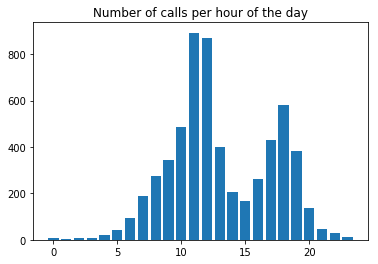

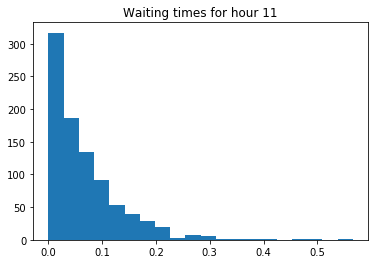

In [2]:
# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.title('Number of calls per hour of the day')
plt.show()

# Plot histogram of waiting times for hour
hour_index = 11
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

### Modeling

In [3]:
call_center_data = {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 0.25,   # gamma distribution
        'calls': waiting_times_hour,  # number of patients per trial
        'num_calls' : len(waiting_times_hour)}


stan_code = """

data {
    real<lower=0> alpha; // fixed prior hyperparameter
    real<lower=0> beta; // fixed prior hyperparameter
    int<lower=0> num_calls ;// Number of calls
    real<lower=0> calls[num_calls]; // wait time for each call
    }

parameters {

    real<lower=0> lambda; // Rate parameter of the Exponential Liklihood
    
    }

model {

    lambda ~ gamma(alpha, beta); // Prior over Lambda
    for (i in 1:num_calls) {
        calls[i] ~ exponential(lambda); // Likelihood function
        }
    }

"""      

In [4]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95de4b763fa0b52ab6b55c7fdee05d3b NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/97/68hd8rkd3b76zwkf67y9mpzh0000gn/T/tmp7wdam5fw/stanfit4anon_model_95de4b763fa0b52ab6b55c7fdee05d3b_377905980241024536.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
# Generate posterior samples
results = stan_model.sampling(data=call_center_data)
print(results.stansummary(pars = ['lambda']))

Inference for Stan model: anon_model_95de4b763fa0b52ab6b55c7fdee05d3b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda  14.86    0.01   0.47  13.93  14.54  14.86  15.17  15.82   1671    1.0

Samples were drawn using NUTS at Fri Oct 19 22:14:40 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


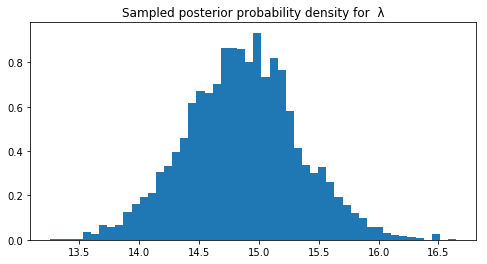

Posterior 95% confidence interval over λ : [13.93119791 15.82184776]


In [6]:
# Plot posterior histograms

samples = results.extract()

plt.figure(figsize=(8,4))
plt.hist(samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for  λ')
plt.show()

print('Posterior 95% confidence interval over λ :', 
      np.percentile(samples['lambda'], [2.5, 97.5]))

# Normal Likelihood with Normal-Inverse-Gamma Prior

In this task, we compute the posterior distribution over the mean $x$ and variance $\sigma^2$ of normally distributed data.

For this model, we are using a normal liklihood function. We can see from its histogram that the data is approximately normally distributed. The normal liklihood has two parameters, the mean, $x$, and the variance, $\sigma^2$. We are using a normal-inverse-gamma distribution as our prior. It has the following hyperperameters: 

* mu = 0  
* nu = 0.054
* alpha = 1.12
* beta = 0.4


Mu is the prior mean, and the smaller nu is, the more uncertain we are about the prior mean. Alpha and beta control the marginal prior over the variance. These fixed prior hyperparameters were provided in the task. 

Because the normal-inverse-gamma is a conjugate prior distribution to the normal distribution, the posterior distribution is also a normal-inverse-gamma distribution. This distribution was found analytically, and produced the following confidence intervals.


Posterior 95% confidence interval over $x$: [2.800, 3.328]

Posterior 95% confidence interval over $\sigma^2$: [2.975, 4.396]



#### Results

The model was coded into stan. It produced the following confidence intervals.

Posterior 95% confidence interval over x : [2.800 3.333]

Posterior 95% confidence interval over sigma2 : [3.004 4.358]


This matches the result from the analytical computation.


The `n_eff` values for both $x$ and $\sigma^2$ were over 3000, and the `rhat` values were 1.0, which both indicate that sampling was succesful.

10 samples from the normal-inverse-gamma posterior distribution an be seen below.

### Importing

200 data


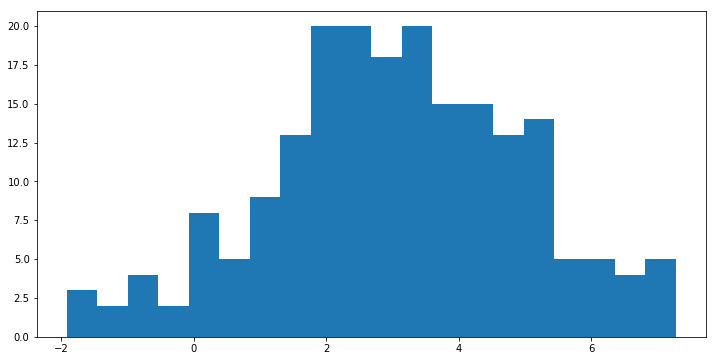

Data sample mean: 3.065080189542003
Data sample variance: 3.6152141787699223


In [7]:
normal_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(normal_data), "data")

# Plot a histogram of the data. The data looks normally distributed
plt.figure(figsize=(12, 6))
plt.hist(normal_data, bins=20)
plt.show()

# Calculate the sample mean and variance of the data
print('Data sample mean:', np.mean(normal_data))
print('Data sample variance:', np.var(normal_data))

### Modeling

In [8]:
stan_data = {
        'mu' : 0,       # fixed prior hyperparameters for the
        'nu' : 0.054,   # normal-inverse-gamma distribution
        'alpha' : 1.12,  
        'beta' : 0.4,
        'normal_data' : normal_data,
        'num_data' : len(normal_data)}

stan_code = """

data {
    real<lower=0> mu; // fixed prior hyperparameters
    real<lower=0> nu; 
    real<lower=0> alpha; 
    real<lower=0> beta; 
    
    int<lower=0> num_data ;// Number of data
    real normal_data[num_data]; // Data from normal distribution
    }

parameters {

    real<lower=0> sigma2; // The variance of the likelihood function
    real  x; // The mean of the likelihood function
    }

model {

    sigma2 ~ inv_gamma(alpha, beta); // Normal-Inverse-Gamma Prior
    x ~ normal(mu,sqrt(sigma2 / nu)); // over sigma2 and x
    for (i in 1:num_data) {
        normal_data[i] ~ normal(x, sqrt(sigma2)); // Likelihood function
        }
    }

"""  

In [9]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_623d005bbca361f51c11d426964cb408 NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/97/68hd8rkd3b76zwkf67y9mpzh0000gn/T/tmpem24xf1u/stanfit4anon_model_623d005bbca361f51c11d426964cb408_6931755486365956474.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
# Generate posterior samples
results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars = ['sigma2', 'x']))

Inference for Stan model: anon_model_623d005bbca361f51c11d426964cb408.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma2   3.62  6.0e-3   0.35    3.0   3.37   3.59   3.84   4.36   3506    1.0
x        3.06  2.5e-3   0.13    2.8   2.97   3.06   3.15   3.33   2870    1.0

Samples were drawn using NUTS at Fri Oct 19 22:16:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [11]:
# Show posterior confidence intervals

samples = results.extract()

print('Posterior 95% confidence interval over sigma2 :', 
      np.percentile(samples['sigma2'], [2.5, 97.5]))
print('Posterior 95% confidence interval over x :', 
      np.percentile(samples['x'], [2.5, 97.5]))

Posterior 95% confidence interval over sigma2 : [3.00366153 4.35839605]
Posterior 95% confidence interval over x : [2.80000198 3.33325104]


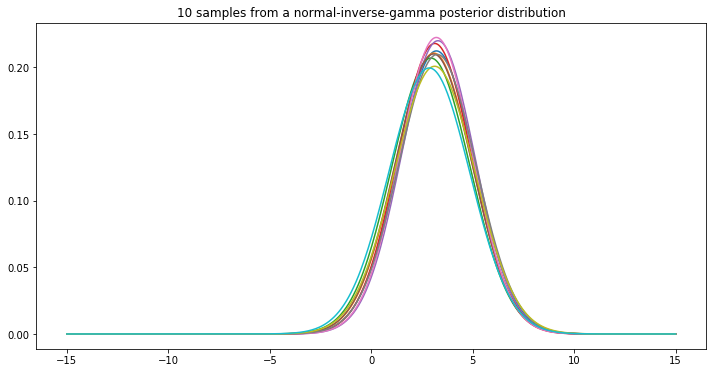

In [14]:
# Take the first ten samples
sigma2s = samples['sigma2'][:10]
xs = samples['x'][:10]

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(10):
    plot_y = stats.norm.pdf(plot_x, loc= xs[i], scale=np.sqrt(sigma2s[i]))
    plt.plot(plot_x, plot_y)
plt.title('10 samples from a normal-inverse-gamma posterior distribution')
plt.show()

#  Log-Normal with Normal-Inverse-Gamma Prior

In this task, we compute the posterior distribution over the mean $x$ and variance $\sigma^2$ of log-normally distributed data.

We first see that the data is not normally distributed. It is skewed to the right and all values are positive. In order to use a normal liklihood function, we take the log of all of the data. Thus, we are making a log-normal model. Once we log the data, we can use a normal liklihood function. 

For this model, we are using a normal liklihood function. The normal liklihood has two parameters, the mean, $x$, and the variance, $\sigma^2$. We are using a normal-inverse-gamma distribution as our prior. It has the following hyperperameters: 

* mu = 2.3
* nu = 0.1
* alpha = 2
* beta = 5


Mu is the prior mean, and the smaller nu is, the more uncertain we are about the prior mean. Alpha and beta control the marginal prior over the variance. These fixed prior hyperparameters were provided in the task. 

Because the normal-inverse-gamma is a conjugate prior distribution to the normal distribution, the posterior distribution is also a normal-inverse-gamma distribution. This distribution was found analytically, and produced the following confidence intervals.


Posterior 95% confidence interval over $x$: [1.83, 1.95]

Posterior 95% confidence interval over $\sigma^2$: [0.44, 0.56]



#### Results

The model was coded into stan. It produced the following confidence intervals.

Posterior 95% confidence interval over x : [1.83, 1.96]

Posterior 95% confidence interval over sigma2 : [0.44, 0.56]


This matches the result from the analytical computation.


The `n_eff` values for both $x$ and $\sigma^2$ were over 3000, and the `rhat` values were 1.0, which both indicate that sampling was succesful.

10 samples from the normal-inverse-gamma posterior distribution on top of the histogram of the original data can be seen below.

500 data, min: 1.051827, max: 28.942578


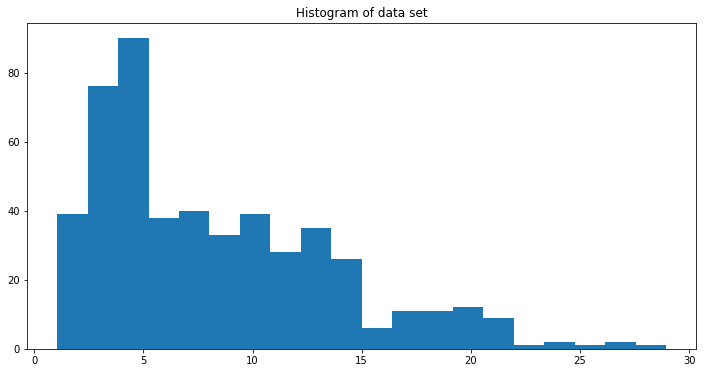

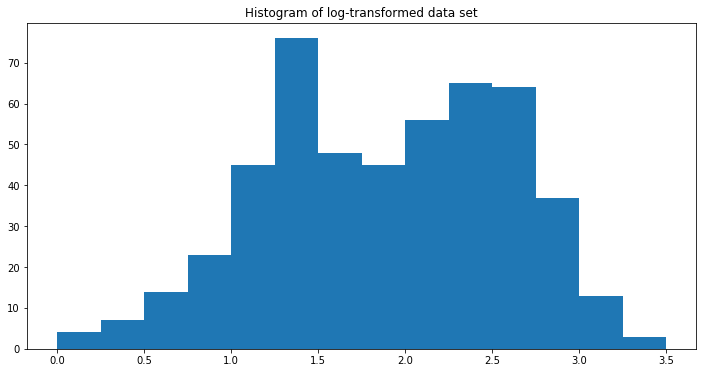

In [15]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
hrtem_data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(hrtem_data), min(hrtem_data), max(hrtem_data)))

# Data are very skewed and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(hrtem_data, bins=20)
plt.title('Histogram of data set')
plt.show()

# Transform the data to make it normal
log_hrtem_data = np.log(hrtem_data)

plt.figure(figsize=(12,6))
plt.hist(log_hrtem_data, bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()

In [16]:
stan_data = {
        'mu' : 2.3,   # fixed prior hyperparameters for the
        'nu' : 0.1,   # normal-inverse-gamma distribution
        'alpha' : 2,  
        'beta' : 5,
        'log_hrtem_data' : log_hrtem_data,
        'num_data' : len(hrtem_data)}

stan_code = """

data {
    real<lower=0> mu; // fixed prior hyperparameters
    real<lower=0> nu; 
    real<lower=0> alpha; 
    real<lower=0> beta; 
    
    int<lower=0> num_data ;// Number of data
    real <lower=0> log_hrtem_data[num_data]; // Log transformed hrtem data
    }

parameters {

    real<lower=0> sigma2; // The variance of the likelihood function
    real  x; // The mean of the likelihood function
    }

model {

    sigma2 ~ inv_gamma(alpha, beta); // Normal-Inverse-Gamma Prior
    x ~ normal(mu,sqrt(sigma2 / nu)); // over sigma2 and x
    for (i in 1:num_data) {
        log_hrtem_data[i] ~ normal(x, sqrt(sigma2)); // Likelihood function
        }
    }

"""  

In [17]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b994a298c06ec4a3efde1f415a0722c9 NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/97/68hd8rkd3b76zwkf67y9mpzh0000gn/T/tmpjrxwfvla/stanfit4anon_model_b994a298c06ec4a3efde1f415a0722c9_8869818180146837946.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [18]:
# Generate posterior samples
results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars = ['sigma2', 'x']))

Inference for Stan model: anon_model_b994a298c06ec4a3efde1f415a0722c9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma2    0.5  5.6e-4   0.03   0.44   0.47   0.49   0.52   0.56   3176    1.0
x        1.89  5.4e-4   0.03   1.83   1.87   1.89   1.91   1.96   3582    1.0

Samples were drawn using NUTS at Fri Oct 19 22:20:51 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [19]:
# Show posterior confidence intervals

samples = results.extract()

print('Posterior 95% confidence interval over sigma2 :', 
      np.percentile(samples['sigma2'], [2.5, 97.5]))
print('Posterior 95% confidence interval over x :', 
      np.percentile(samples['x'], [2.5, 97.5]))

Posterior 95% confidence interval over sigma2 : [0.43924298 0.56082155]
Posterior 95% confidence interval over x : [1.82804557 1.95715216]


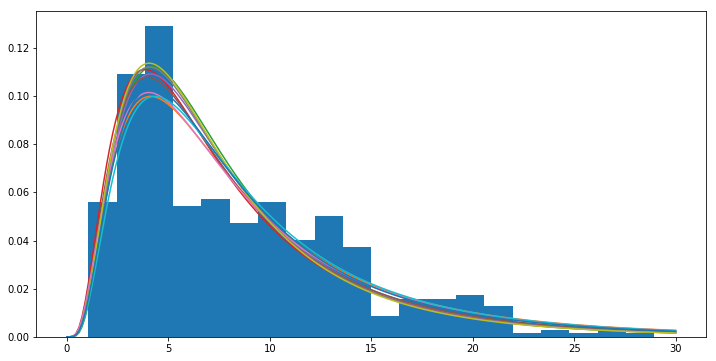

In [21]:
# Take the first ten samples
sigma2s = samples['sigma2'][:10]
xs = samples['x'][:10]

# Plot 10 pdfs over the histogram of the original data.
plt.figure(figsize=(12,6))
plt.hist(hrtem_data, bins=20, density=True)
plot_x = np.linspace(0, 30, 200)
for i in range(10):
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(sigma2s[i]),
                               scale=np.exp(xs[i]))
    plt.plot(plot_x, plot_y)
plt.show()